<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/AUGMENTATION_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc

In [5]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [20]:
img_dim=128
transform = transforms.Compose(
    [transforms.Resize((img_dim,img_dim),interpolation=2),
     transforms.RandomAffine(degrees=5,translate=(0.15,0.15),scale=(0.75,1.25)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [21]:
!git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

data_dir='Transfer-Learning-COVID-19/dataset_3_classes/'


fatal: destination path 'Transfer-Learning-COVID-19' already exists and is not an empty directory.


In [31]:
batch_size_train=64
batch_size_test=27
trainset = torchvision.datasets.ImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
trainloader = torch.utils.data.DataLoader(
          trainset, batch_size=batch_size_train, shuffle=True)
testset = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)
testloader = torch.utils.data.DataLoader(
          testset, batch_size=batch_size_test, shuffle=True)

classes = ("covid", "normal", "pneumonia_bac")

In [32]:
# trainset = torchvision.datasets.STL10(root='./data', split='train',
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.STL10(root='./data', split='test',
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# classes = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")

In [33]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

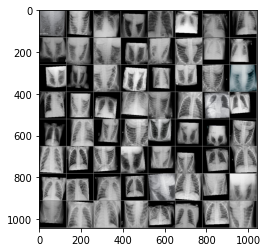

covid pneumonia_bac covid pneumonia_bac covid covid pneumonia_bac pneumonia_bac covid pneumonia_bac covid covid pneumonia_bac normal pneumonia_bac pneumonia_bac covid covid normal covid pneumonia_bac covid normal covid pneumonia_bac pneumonia_bac covid covid pneumonia_bac normal covid normal covid pneumonia_bac pneumonia_bac normal covid covid covid normal pneumonia_bac normal normal covid pneumonia_bac normal covid normal normal covid pneumonia_bac normal covid normal pneumonia_bac covid pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac covid covid normal pneumonia_bac


In [34]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size_train)))

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, 3),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [36]:
hidden_size=32
channels_size=3

net=CNN(hidden_size, channels_size)

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [38]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=32768, out_feat


Epoch: [1]  => Loss: [1.104]



Epoch: [2]  => Loss: [1.075]



Epoch: [3]  => Loss: [1.052]



Epoch: [4]  => Loss: [0.994]



Epoch: [5]  => Loss: [0.978]



Epoch: [6]  => Loss: [0.891]



Epoch: [7]  => Loss: [0.880]



Epoch: [8]  => Loss: [0.816]



Epoch: [9]  => Loss: [0.808]



Epoch: [10]  => Loss: [0.793]



Epoch: [10]  => Test: [1]  => Loss: [0.823]
Epoch: [10]  => Confusion Matrix Test: [1]  => Total Accuracy: [0.815]


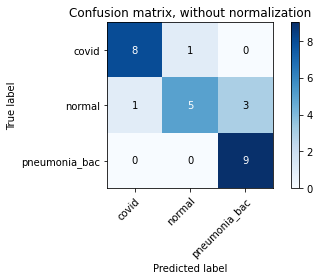

Epoch: [10]  => Evaluation Confusion Matrix Test: [1]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.888889 │      0.888889 │      0.9      │  0.888889 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.833333 │      0.555556 │      0.923077 │  0.666667 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.75     │      1        │      0.666667 │  0.857143 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [11]  => Loss: [0.745]



Epoch: [12]  => Loss: [0.752]



Epoch: [13]  => Loss: [0.758]



Epoch: [14]  => Loss: [0.746]



Epoch: [15]  => Loss: [0.738]



Epoch: [16]  => Loss: [0.752]



Epoch: [17]  => Loss: [0.759]



Epoch: [18]  => Loss: [0.664]



Epoch: [19]  => Loss: [0.722]



Epoch: [20]  => Loss: [0.718]



Epoch: [20]  => Test: [2]  => Loss: [0.731]
Epoch: [20]  => Confusion Matrix Test: [2]  => Total Accuracy: [0.815]


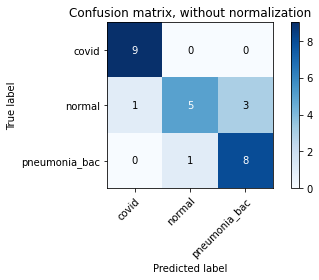

Epoch: [20]  => Evaluation Confusion Matrix Test: [2]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.9      │      1        │      0.888889 │  0.947368 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.833333 │      0.555556 │      0.923077 │  0.666667 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.727273 │      0.888889 │      0.7      │  0.8      │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [21]  => Loss: [0.728]



Epoch: [22]  => Loss: [0.718]



Epoch: [23]  => Loss: [0.715]



Epoch: [24]  => Loss: [0.679]



Epoch: [25]  => Loss: [0.721]



Epoch: [26]  => Loss: [0.680]



Epoch: [27]  => Loss: [0.683]



Epoch: [28]  => Loss: [0.667]



Epoch: [29]  => Loss: [0.705]



Epoch: [30]  => Loss: [0.765]



Epoch: [30]  => Test: [3]  => Loss: [0.827]
Epoch: [30]  => Confusion Matrix Test: [3]  => Total Accuracy: [0.704]


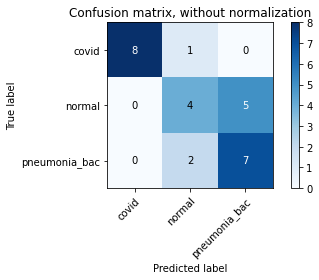

Epoch: [30]  => Evaluation Confusion Matrix Test: [3]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      0.888889 │      1        │  0.941176 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.571429 │      0.444444 │      0.785714 │  0.5      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.583333 │      0.777778 │      0.545455 │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [31]  => Loss: [0.683]



Epoch: [32]  => Loss: [0.662]



Epoch: [33]  => Loss: [0.726]



Epoch: [34]  => Loss: [0.674]



Epoch: [35]  => Loss: [0.653]



Epoch: [36]  => Loss: [0.665]



Epoch: [37]  => Loss: [0.649]



Epoch: [38]  => Loss: [0.636]



Epoch: [39]  => Loss: [0.672]



Epoch: [40]  => Loss: [0.681]



Epoch: [40]  => Test: [4]  => Loss: [0.753]
Epoch: [40]  => Confusion Matrix Test: [4]  => Total Accuracy: [0.778]


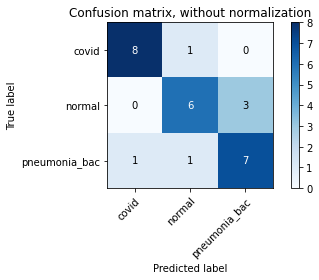

Epoch: [40]  => Evaluation Confusion Matrix Test: [4]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.888889 │      0.888889 │      0.9      │  0.888889 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.75     │      0.666667 │      0.833333 │  0.705882 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.7      │      0.777778 │      0.727273 │  0.736842 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [41]  => Loss: [0.661]



Epoch: [42]  => Loss: [0.688]



Epoch: [43]  => Loss: [0.665]



Epoch: [44]  => Loss: [0.661]



Epoch: [45]  => Loss: [0.637]



Epoch: [46]  => Loss: [0.679]



Epoch: [47]  => Loss: [0.642]



Epoch: [48]  => Loss: [0.659]



Epoch: [49]  => Loss: [0.636]



Epoch: [50]  => Loss: [0.646]



Epoch: [50]  => Test: [5]  => Loss: [0.782]
Epoch: [50]  => Confusion Matrix Test: [5]  => Total Accuracy: [0.741]


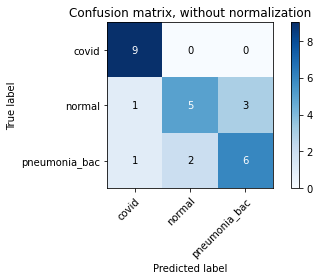

Epoch: [50]  => Evaluation Confusion Matrix Test: [5]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.818182 │      1        │      0.777778 │  0.9      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.714286 │      0.555556 │      0.846154 │  0.625    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.666667 │      0.666667 │      0.75     │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [51]  => Loss: [0.666]



Epoch: [52]  => Loss: [0.660]



Epoch: [53]  => Loss: [0.639]



Epoch: [54]  => Loss: [0.731]



Epoch: [55]  => Loss: [0.669]



Epoch: [56]  => Loss: [0.662]



Epoch: [57]  => Loss: [0.650]



Epoch: [58]  => Loss: [0.653]



Epoch: [59]  => Loss: [0.667]



Epoch: [60]  => Loss: [0.662]



Epoch: [60]  => Test: [6]  => Loss: [0.807]
Epoch: [60]  => Confusion Matrix Test: [6]  => Total Accuracy: [0.778]


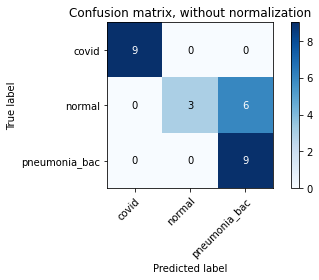

Epoch: [60]  => Evaluation Confusion Matrix Test: [6]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │        1   │      1        │      1        │      1    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │        1   │      0.333333 │      1        │      0.5  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │        0.6 │      1        │      0.333333 │      0.75 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [61]  => Loss: [0.627]



Epoch: [62]  => Loss: [0.622]



Epoch: [63]  => Loss: [0.662]



Epoch: [64]  => Loss: [0.651]



Epoch: [65]  => Loss: [0.635]



Epoch: [66]  => Loss: [0.634]



Epoch: [67]  => Loss: [0.661]



Epoch: [68]  => Loss: [0.625]



Epoch: [69]  => Loss: [0.692]



Epoch: [70]  => Loss: [0.689]



Epoch: [70]  => Test: [7]  => Loss: [0.839]
Epoch: [70]  => Confusion Matrix Test: [7]  => Total Accuracy: [0.704]


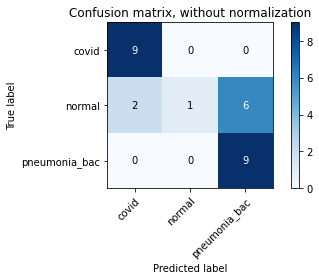

Epoch: [70]  => Evaluation Confusion Matrix Test: [7]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.818182 │      1        │      0.777778 │      0.9  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   1        │      0.111111 │      1        │      0.2  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.6      │      1        │      0.333333 │      0.75 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [71]  => Loss: [0.658]



Epoch: [72]  => Loss: [0.641]



Epoch: [73]  => Loss: [0.637]



Epoch: [74]  => Loss: [0.657]



Epoch: [75]  => Loss: [0.623]



Epoch: [76]  => Loss: [0.628]



Epoch: [77]  => Loss: [0.684]



Epoch: [78]  => Loss: [0.646]



Epoch: [79]  => Loss: [0.653]



Epoch: [80]  => Loss: [0.608]



Epoch: [80]  => Test: [8]  => Loss: [0.782]
Epoch: [80]  => Confusion Matrix Test: [8]  => Total Accuracy: [0.741]


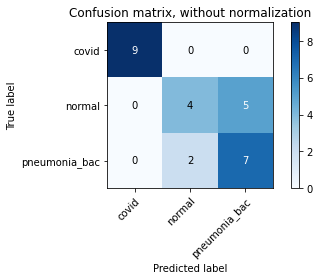

Epoch: [80]  => Evaluation Confusion Matrix Test: [8]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.666667 │      0.444444 │      0.857143 │  0.533333 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.583333 │      0.777778 │      0.545455 │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [81]  => Loss: [0.621]



Epoch: [82]  => Loss: [0.659]



Epoch: [83]  => Loss: [0.634]



Epoch: [84]  => Loss: [0.704]



Epoch: [85]  => Loss: [0.650]



Epoch: [86]  => Loss: [0.652]



Epoch: [87]  => Loss: [0.668]



Epoch: [88]  => Loss: [0.615]



Epoch: [89]  => Loss: [0.648]



Epoch: [90]  => Loss: [0.642]



Epoch: [90]  => Test: [9]  => Loss: [0.778]
Epoch: [90]  => Confusion Matrix Test: [9]  => Total Accuracy: [0.778]


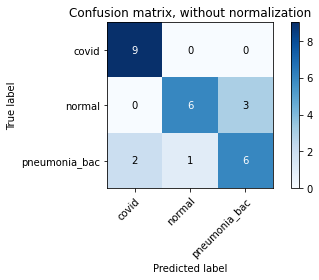

Epoch: [90]  => Evaluation Confusion Matrix Test: [9]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.818182 │      1        │      0.777778 │  0.9      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.857143 │      0.666667 │      0.916667 │  0.75     │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.666667 │      0.666667 │      0.75     │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [91]  => Loss: [0.622]



Epoch: [92]  => Loss: [0.630]



Epoch: [93]  => Loss: [0.619]



Epoch: [94]  => Loss: [0.633]



Epoch: [95]  => Loss: [0.650]



Epoch: [96]  => Loss: [0.653]



Epoch: [97]  => Loss: [0.671]



Epoch: [98]  => Loss: [0.620]



Epoch: [99]  => Loss: [0.708]



Epoch: [100]  => Loss: [0.620]



Epoch: [100]  => Test: [10]  => Loss: [0.833]
Epoch: [100]  => Confusion Matrix Test: [10]  => Total Accuracy: [0.630]


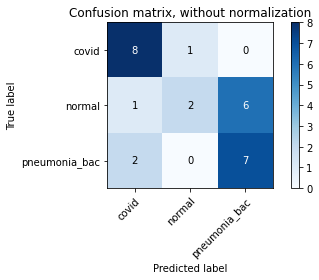

Epoch: [100]  => Evaluation Confusion Matrix Test: [10]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.727273 │      0.888889 │      0.7      │  0.8      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.666667 │      0.222222 │      0.9375   │  0.333333 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.538462 │      0.777778 │      0.454545 │  0.636364 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [101]  => Loss: [0.631]



Epoch: [102]  => Loss: [0.654]



Epoch: [103]  => Loss: [0.623]



Epoch: [104]  => Loss: [0.628]



Epoch: [105]  => Loss: [0.627]



Epoch: [106]  => Loss: [0.651]



Epoch: [107]  => Loss: [0.615]



Epoch: [108]  => Loss: [0.672]



Epoch: [109]  => Loss: [0.617]



Epoch: [110]  => Loss: [0.650]



Epoch: [110]  => Test: [11]  => Loss: [0.831]
Epoch: [110]  => Confusion Matrix Test: [11]  => Total Accuracy: [0.704]


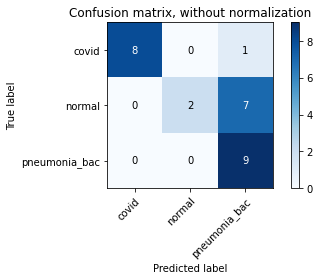

Epoch: [110]  => Evaluation Confusion Matrix Test: [11]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      0.888889 │      1        │  0.941176 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   1        │      0.222222 │      1        │  0.363636 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.529412 │      1        │      0.111111 │  0.692308 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [111]  => Loss: [0.637]



Epoch: [112]  => Loss: [0.640]



Epoch: [113]  => Loss: [0.639]



Epoch: [114]  => Loss: [0.631]



Epoch: [115]  => Loss: [0.614]



Epoch: [116]  => Loss: [0.666]



Epoch: [117]  => Loss: [0.605]



Epoch: [118]  => Loss: [0.611]



Epoch: [119]  => Loss: [0.609]



Epoch: [120]  => Loss: [0.629]



Epoch: [120]  => Test: [12]  => Loss: [0.796]
Epoch: [120]  => Confusion Matrix Test: [12]  => Total Accuracy: [0.778]


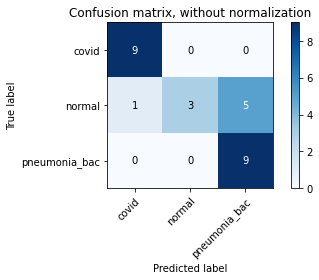

Epoch: [120]  => Evaluation Confusion Matrix Test: [12]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.9      │      1        │      0.888889 │  0.947368 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   1        │      0.333333 │      1        │  0.5      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.642857 │      1        │      0.444444 │  0.782609 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [121]  => Loss: [0.653]



Epoch: [122]  => Loss: [0.657]



Epoch: [123]  => Loss: [0.650]



Epoch: [124]  => Loss: [0.646]



Epoch: [125]  => Loss: [0.623]



Epoch: [126]  => Loss: [0.637]



Epoch: [127]  => Loss: [0.616]



Epoch: [128]  => Loss: [0.627]



Epoch: [129]  => Loss: [0.619]



Epoch: [130]  => Loss: [0.626]



Epoch: [130]  => Test: [13]  => Loss: [0.718]
Epoch: [130]  => Confusion Matrix Test: [13]  => Total Accuracy: [0.852]


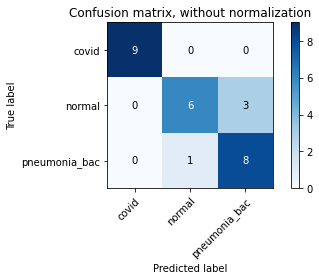

Epoch: [130]  => Evaluation Confusion Matrix Test: [13]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │      1    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.857143 │      0.666667 │      0.916667 │      0.75 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.727273 │      0.888889 │      0.7      │      0.8  │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [131]  => Loss: [0.602]



Epoch: [132]  => Loss: [0.603]



Epoch: [133]  => Loss: [0.621]



Epoch: [134]  => Loss: [0.613]



Epoch: [135]  => Loss: [0.607]



Epoch: [136]  => Loss: [0.630]



Epoch: [137]  => Loss: [0.629]



Epoch: [138]  => Loss: [0.632]



Epoch: [139]  => Loss: [0.608]



Epoch: [140]  => Loss: [0.637]



Epoch: [140]  => Test: [14]  => Loss: [0.725]
Epoch: [140]  => Confusion Matrix Test: [14]  => Total Accuracy: [0.852]


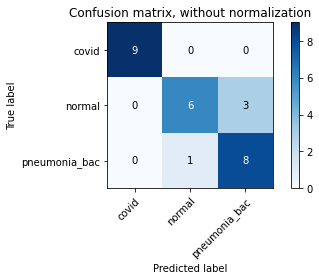

Epoch: [140]  => Evaluation Confusion Matrix Test: [14]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │      1    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.857143 │      0.666667 │      0.916667 │      0.75 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.727273 │      0.888889 │      0.7      │      0.8  │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [141]  => Loss: [0.647]



Epoch: [142]  => Loss: [0.629]



Epoch: [143]  => Loss: [0.638]



Epoch: [144]  => Loss: [0.630]



Epoch: [145]  => Loss: [0.612]



Epoch: [146]  => Loss: [0.609]



Epoch: [147]  => Loss: [0.609]



Epoch: [148]  => Loss: [0.615]



Epoch: [149]  => Loss: [0.645]



Epoch: [150]  => Loss: [0.607]



Epoch: [150]  => Test: [15]  => Loss: [0.759]
Epoch: [150]  => Confusion Matrix Test: [15]  => Total Accuracy: [0.778]


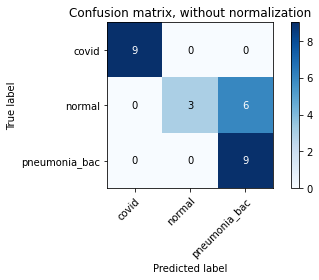

Epoch: [150]  => Evaluation Confusion Matrix Test: [15]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │        1   │      1        │      1        │      1    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │        1   │      0.333333 │      1        │      0.5  │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │        0.6 │      1        │      0.333333 │      0.75 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛
Finished Training


In [39]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    running_loss = 0.0
    if (epoch+1)%10==0:
        running_loss_=0
        with torch.no_grad():
            for data in notebook.tqdm(testloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                outputs = net(inputs)

                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                running_loss_ += loss.item()

                cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)
                
                tot_acc=np.trace(cm)/np.sum(cm)

                sensitivity = list(0. for i in range(cm.shape[0]))
                specificity = list(0. for i in range(cm.shape[0]))
                accuracy = list(0. for i in range(cm.shape[0]))
                f1score = list(0. for i in range(cm.shape[0]))
                table = list(0. for i in range(cm.shape[0]))

                for i in range(cm.shape[0]):
                    TP = cm[i,i]
                    FN = np.sum(cm[i,:]) - cm[i,i]
                    FP = np.sum(cm[:,i]) - cm[i,i]
                    TN = (np.sum(cm)-np.sum(cm[i,:])-np.sum(cm[:,i]))
                    FP = np.sum(cm[:,i]) - cm[i,i]
                    accuracy[i] = TP/ (TP + FP) 
                    sensitivity[i] = TP/ (TP + FN) 
                    specificity[i] = TN /(TN + FP) 
                    f1score[i]= 2*(accuracy[i]*sensitivity[i])/(accuracy[i]+sensitivity[i])
                    table[i]=[classes[i], accuracy[i], sensitivity[i], specificity[i], f1score[i]]
            
            print("Epoch: [%d]"%(epoch + 1)," => Test: [%d]" %(int((epoch+1)/10)),' => Loss: [%.3f]' %(running_loss_ / len(testloader)))
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy: [%.3f]" %(tot_acc))

            plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))

print('Finished Training')
PATH = './stl10_net.pth'
torch.save(net.state_dict(), PATH)

In [40]:
# net.load_state_dict(torch.load(PATH))
# net.eval()

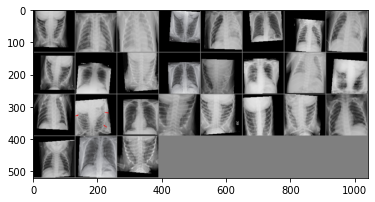

GroundTruth:  normal pneumonia_bac pneumonia_bac covid pneumonia_bac covid normal pneumonia_bac normal covid pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid covid normal normal pneumonia_bac normal normal normal covid normal


In [41]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(27)))

In [42]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(27)))

Predicted:  pneumonia_bac pneumonia_bac pneumonia_bac covid covid covid normal pneumonia_bac pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid covid pneumonia_bac normal pneumonia_bac pneumonia_bac normal pneumonia_bac covid normal


In [43]:
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, target_names=classes, digits=3))

               precision    recall  f1-score   support

        covid      0.900     1.000     0.947         9
       normal      1.000     0.444     0.615         9
pneumonia_bac      0.615     0.889     0.727         9

     accuracy                          0.778        27
    macro avg      0.838     0.778     0.763        27
 weighted avg      0.838     0.778     0.763        27



[[9 0 0]
 [0 4 5]
 [1 0 8]]


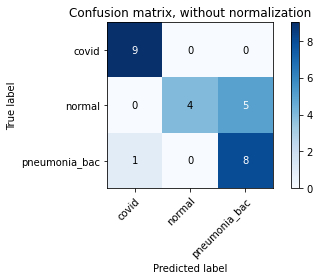

In [44]:
cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

print(cm)

plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>


In [45]:
tot_acc=np.trace(cm)/np.sum(cm)

sensitivity = list(0. for i in range(cm.shape[0]))
specificity = list(0. for i in range(cm.shape[0]))

for i in range(cm.shape[0]):
  TP = cm[i,i]
  FN = np.sum(cm[i,:]) - cm[i,i]
  TN = (np.sum(cm)-np.sum(cm[i,:])-np.sum(cm[:,i]))
  FP = np.sum(cm[:,i]) - cm[i,i]
  sensitivity[i]= TP/ (TP + FN) 
  specificity[i]= TN /(TN + FP) 
  print("sensitivity for class ",classes[i],": ", sensitivity[i].round(3)) # probability of a positive test given that the patient has the disease
  print("specificity for class ",classes[i],": ", specificity[i].round(3)) # the percentage of healthy people who are correctly identified as not having the condition

# print("total sensitivity: ", (np.sum(sensitivity)/len(classes)).round(3)) # needed?
# print("total specificity: ", (np.sum(specificity)/len(classes)).round(3)) # needed?
print("tot_acc: ",tot_acc.round(3))


sensitivity for class  covid :  1.0
specificity for class  covid :  0.889
sensitivity for class  normal :  0.444
specificity for class  normal :  1.0
sensitivity for class  pneumonia_bac :  0.889
specificity for class  pneumonia_bac :  0.5
tot_acc:  0.778


In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


In [47]:
class_correct = list(0. for i in range(3)) #classes
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(27): #batch
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of covid : 100 %
Accuracy of normal : 22 %
Accuracy of pneumonia_bac : 77 %
